# Metropolis

In [14]:
import random
from collections import OrderedDict
import tqdm
import math
import time
import torch

#random.seed(42)
class Metropolis(object):
    def __init__(self,model, training, loss_fn, stdev, iterations):
        self.training = training
        self.stdev = stdev
        self.iterations = iterations
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.model = model
        
        self.loss_fn = loss_fn
        self.loss_prev = 0
        
        self.state_dict = {}
        
        self.acceptance_ratio = 0
        
        self.history = {}

    
    '''RANDOM INITIALIZATION OF THE MODEL'''
    def initializeModel(self):
        self.state_dict = {}
        for name, param in self.model.named_parameters():
            size = list(param.size())
            mean = torch.zeros(size)
            std = torch.ones(size) * self.stdev
            new_param = torch.normal(mean, std) #initialising the params of each layer according to N(0,std)
            self.state_dict[name] = new_param

        state_dict_zero = OrderedDict(self.state_dict)
        self.model.load_state_dict(state_dict_zero, strict=False) #loading the params on the model
        self.model = model.to(self.device)
    
    '''NEGATIVE LOG PRIOR: REGULARIZATION TERM'''
    def negative_log_prior(self,params):
        regularization_term = 0
        for name, W in params:
            regularization_term += W.norm(2)
        return 0.5*regularization_term
    
    '''FORWARD'''
    def forward(self):
        with torch.no_grad():
            X, y = self.training
            X = X.to(self.device)
            y = y.to(self.device)
            y_pred = self.model(X)
            loss = self.loss_fn(y_pred, y) + self.negative_log_prior(self.model.named_parameters()) 
            return loss
    
    '''UPDATE OF MODEL PARAMETERS: param += N(0,stdev)'''
    def updateParameters(self):
        new_state_dict = {}
        for name, param in self.state_dict.items():
            size = list(param.size())
            mean = torch.zeros(size)
            std = torch.ones(size) * self.stdev
            new_param = param + torch.normal(mean, std)#creating the new set of parameters of the model, w_new = w_prev + N(0,std)
            new_state_dict[name] = new_param
        #setting the new set of params to the model, in order to test the new loss	
        state_dict_it = OrderedDict(new_state_dict)
        self.model.load_state_dict(state_dict_it, strict=False)
        return new_state_dict
    
    '''MAIN'''
    def run(self):
        self.initializeModel()
        self.loss_prev = self.forward()
        print("Initial Loss {}".format(self.loss_prev.item()))

        
        self.history = {
            "model_parameters":[self.state_dict],
            "losses": [self.loss_prev.item()],
            "acceptance_ratio": 0
        }
        
        for i in range(self.iterations):
            start = time.time()
            accepted = False
            new_state_dict = self.updateParameters()
            loss = self.forward()
            
            '''METROPOLIS PROCEDURE: ACCEPTANCE, CONDITIONAL ACCEPTANCE OR REJECTION'''
            if loss.item() < self.loss_prev.item():#direct acceptance
                self.state_dict = new_state_dict #set the set of params as the current accepted one
                self.loss_prev = loss #updating the loss
                self.acceptance_ratio +=1
                accepted = True
            else:
                r = torch.rand(1)
                prob = torch.exp(-loss-(-self.loss_prev))
                if r < prob: #conditional acceptance
                    self.state_dict = new_state_dict
                    self.loss_prev = loss
                    self.acceptance_ratio +=1
                    accepted = True
            end = time.time()
            '''SAVING ACCEPTED MODEL PARAMETERS AND LOSS'''
            self.history["model_parameters"].append(self.state_dict)
            self.history["losses"].append(self.loss_prev)
            self.history["acceptance_ratio"] = self.acceptance_ratio*100/(i+1)
            if (i+1)%(self.iterations/10)==0:
                print("Iteration {}/{}: {}s, Loss: {}, Minor Loss: {}, Accepted: {}, Current Acceptance Ratio: {}".format(
                i+1,self.iterations, round(end-start,1),loss.item(), loss.item()<self.loss_prev.item(), accepted,self.history["acceptance_ratio"]))
            
            state_dict_it = OrderedDict(self.state_dict)
            self.model.load_state_dict(state_dict_it, strict=False) 
            
        return self.history

In [15]:
import numpy as np

data = np.loadtxt('dataSimple/example_data.txt', delimiter=',')
X = data[:,0]
y = data[:,2]

X = np.reshape(X,(X.shape[0],1))
y = np.reshape(y, (y.shape[0],1))

X, y = torch.from_numpy(X).type(torch.FloatTensor), torch.from_numpy(y).type(torch.FloatTensor)

N = X.shape[0] 
M = 280
a, b = np.floor(min(X)), np.ceil(max(X))    
Xtest = torch.from_numpy(np.linspace(a-2, b+2, M).reshape(-1,1)).type(torch.FloatTensor)


In [16]:
from scripts.smallNNClassification import NetClass
model = NetClass()
loss_fn = torch.nn.BCELoss(reduction='sum')
m = Metropolis(model, (X,y),loss_fn, 0.004, 100000)

In [17]:
history = m.run()

Initial Loss 88.8851547241211
Iteration 10000/100000: 0.0s, Loss: 32.007606506347656, Minor Loss: False, Accepted: True, Current Acceptance Ratio: 70.46
Iteration 20000/100000: 0.0s, Loss: 24.944992065429688, Minor Loss: False, Accepted: True, Current Acceptance Ratio: 58.85
Iteration 30000/100000: 0.0s, Loss: 26.620927810668945, Minor Loss: False, Accepted: True, Current Acceptance Ratio: 49.97666666666667
Iteration 40000/100000: 0.0s, Loss: 32.27137756347656, Minor Loss: False, Accepted: False, Current Acceptance Ratio: 45.5775
Iteration 50000/100000: 0.0s, Loss: 28.14250373840332, Minor Loss: False, Accepted: False, Current Acceptance Ratio: 41.776
Iteration 60000/100000: 0.0s, Loss: 30.290178298950195, Minor Loss: False, Accepted: False, Current Acceptance Ratio: 38.415
Iteration 70000/100000: 0.0s, Loss: 54.57183074951172, Minor Loss: False, Accepted: False, Current Acceptance Ratio: 35.70285714285714
Iteration 80000/100000: 0.0s, Loss: 61.59539794921875, Minor Loss: False, Accept

In [18]:
params = history['model_parameters'][3000::100]
outputs = torch.zeros((Xtest.size()[0], len(params)))
print(len(params))
for i,set_param in enumerate(params):
    state_dict_it = OrderedDict(set_param)
    model.load_state_dict(state_dict_it, strict=False) 
    with torch.no_grad():
        outputs[:,i] = torch.squeeze(model(Xtest))
percentile5, percentile95 = np.percentile(outputs.numpy(),5, axis=1), np.percentile(outputs.numpy(),95, axis=1)
mean = torch.mean(outputs, 1)

971


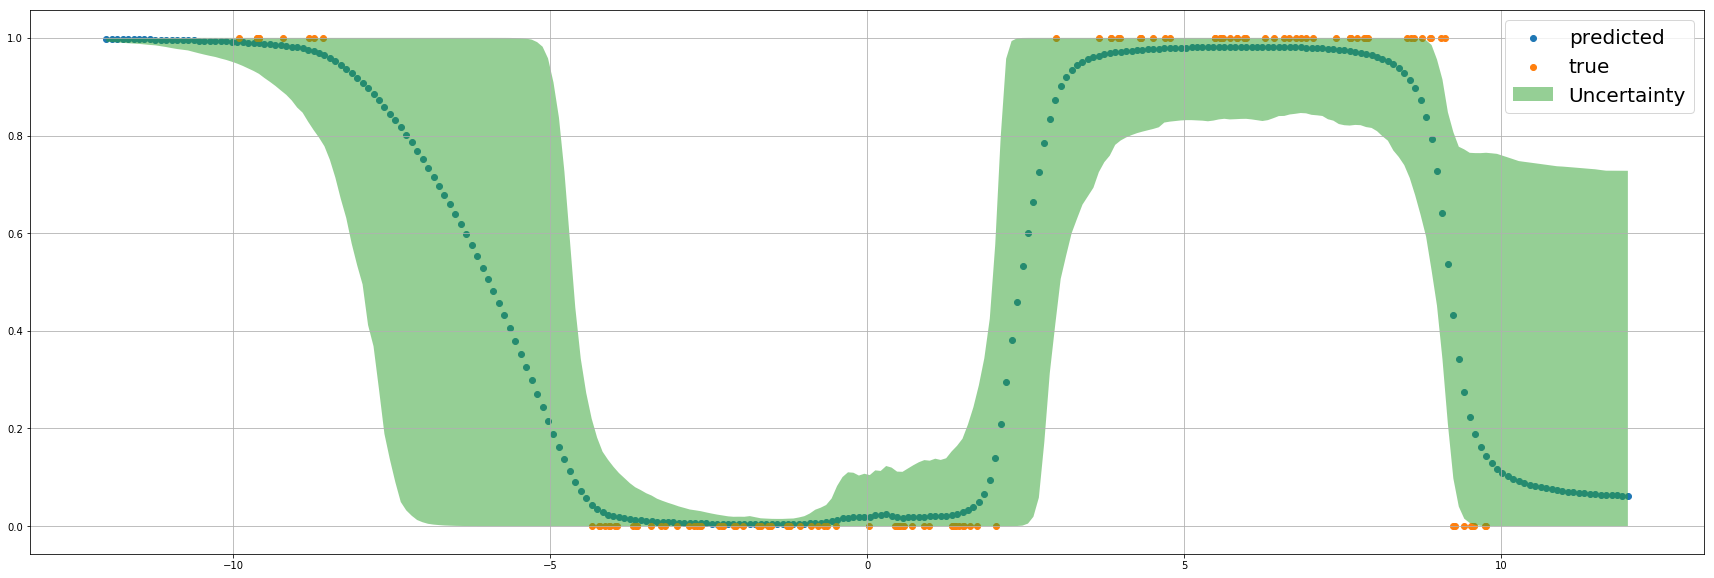

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(30,10))
plt.grid()
plt.scatter(Xtest, mean, label='predicted')
plt.scatter(X, y, label='true')
plt.fill_between(np.array(Xtest).ravel(), 
                 percentile5,
                 percentile95,
                 alpha=0.5, label='Uncertainty')
plt.legend(fontsize=20)
plt.savefig("imgs/MetropolisClassification.png")
plt.show()

In [111]:
import numpy as np

data = np.loadtxt('dataSimple/example_data.txt', delimiter=',')
X = data[:,0]
y = data[:,1]

X = np.reshape(X,(X.shape[0],1))
y = np.reshape(y, (y.shape[0],1))

X, y = torch.from_numpy(X).type(torch.FloatTensor), torch.from_numpy(y).type(torch.FloatTensor)

N = X.shape[0] 
M = 280
a, b = np.floor(min(X)), np.ceil(max(X))    
Xtest = torch.from_numpy(np.linspace(a-2, b+2, M).reshape(-1,1)).type(torch.FloatTensor)


In [112]:
from scripts.smallNNRegression import NetRegr
model = NetRegr()
loss_fn = torch.nn.MSELoss(reduction='sum')
m = Metropolis(model, (X,y),loss_fn, 0.005, 100000)

In [113]:
history = m.run()

Initial Loss 412.4657897949219
Iteration 10000/100000: 0.0s, Loss: 23.854511260986328, Minor Loss: False, Accepted: True, Current Acceptance Ratio: 46.67
Iteration 20000/100000: 0.0s, Loss: 27.787256240844727, Minor Loss: False, Accepted: False, Current Acceptance Ratio: 34.54
Iteration 30000/100000: 0.0s, Loss: 27.860126495361328, Minor Loss: False, Accepted: True, Current Acceptance Ratio: 27.93
Iteration 40000/100000: 0.0s, Loss: 77.92625427246094, Minor Loss: False, Accepted: False, Current Acceptance Ratio: 24.04
Iteration 50000/100000: 0.0s, Loss: 30.236970901489258, Minor Loss: False, Accepted: False, Current Acceptance Ratio: 21.286
Iteration 60000/100000: 0.0s, Loss: 46.77263641357422, Minor Loss: False, Accepted: False, Current Acceptance Ratio: 19.245
Iteration 70000/100000: 0.0s, Loss: 32.442108154296875, Minor Loss: False, Accepted: False, Current Acceptance Ratio: 17.91857142857143
Iteration 80000/100000: 0.0s, Loss: 48.39378356933594, Minor Loss: False, Accepted: False, 

In [114]:
params = history['model_parameters'][3000::100]
outputs = torch.zeros((Xtest.size()[0], len(params)))
for i,set_param in enumerate(params):
    state_dict_it = OrderedDict(set_param)
    model.load_state_dict(state_dict_it, strict=False) 
    with torch.no_grad():
        outputs[:,i] = torch.squeeze(model(Xtest))
percentile5, percentile95 = np.percentile(outputs.numpy(),5, axis=1), np.percentile(outputs.numpy(),95, axis=1)
mean = torch.mean(outputs, 1)

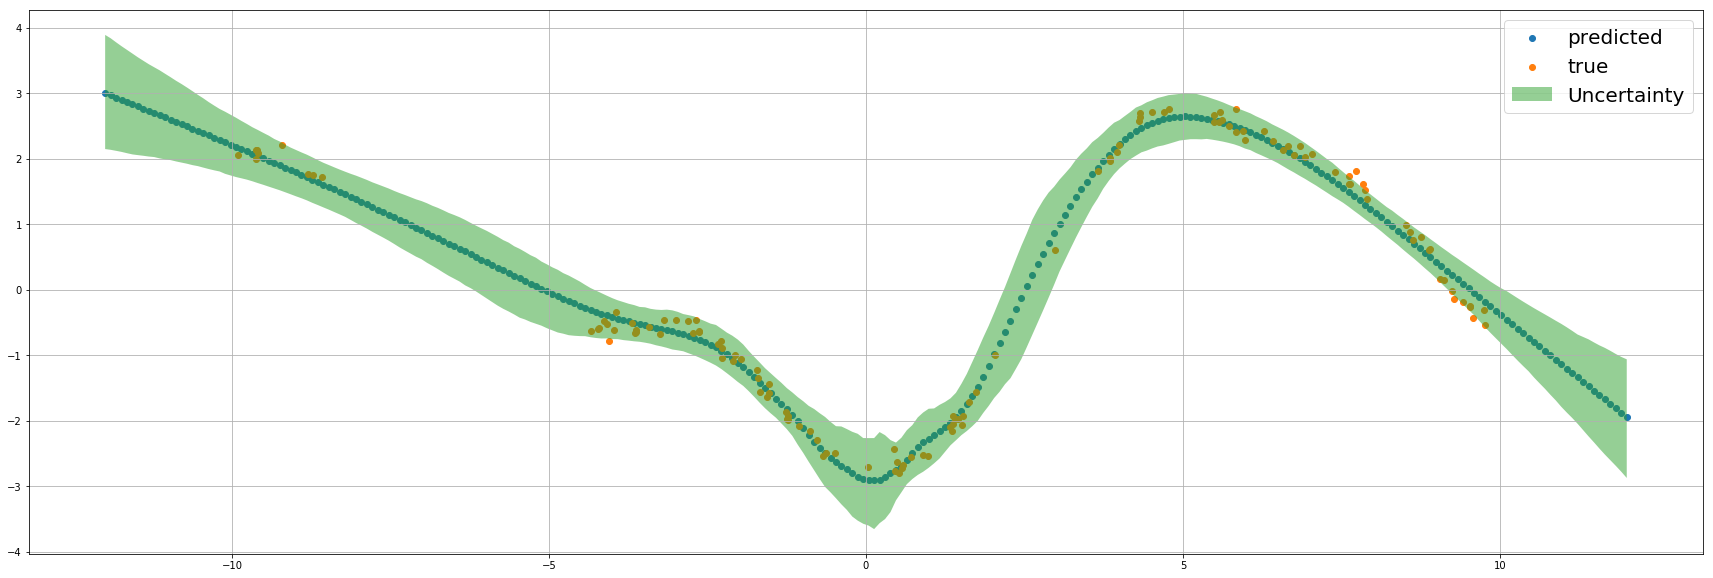

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(30,10))
plt.grid()
plt.scatter(Xtest, mean, label='predicted')
plt.scatter(X, y, label='true')
plt.fill_between(np.array(Xtest).ravel(), 
                 percentile5,
                 percentile95,
                 alpha=0.5, label='Uncertainty')
plt.legend(fontsize=20)
plt.savefig("imgs/MetropolisRegression.png")
plt.show()

# Stochastic Gradient Hamiltonian Monte Carlo

<p>Instead of computing the costly gradient $\nabla U(\theta)$ on the entire dataset $D$, we consider a minibatch $\tilde{D}$ sampled uniformly at random from $D$:
    \begin{equation} \nabla \tilde{U}(\theta) = - \frac{|D|}{|\tilde{D}|} \sum_{x \in \tilde{D}} \nabla log~p(x|\theta)-\nabla log~p(\theta), \quad \tilde{D} \subset D
    \end{equation}</p>
<p>This noisy gradient we assume that can be approximated with:
    \begin{equation} \nabla \tilde{U}(\theta) ≈ \nabla U(\theta)+ N(0, V(\theta)) \end{equation}
    with $V(\theta)$ a covariance matrix depending on the model parameters. As $\tilde{D}$ increases, for the central limit theorem this introduction of a Gaussian random variable become more accurate. Empirically a minibatch in othe order of hundreds of data points is sufficient for the central limit theorem to be accurate</p>

In [20]:
import torch
import numpy as np


## Base Sampler class
## -----------------------------------------------------------------------------

class _BaseSampler:

    def __init__(self, loss_module):
        self.loss_module = loss_module
        self.sampled_weights = []

    def sample(self, nsamples=1, **args):
        raise NotImplementedError()

    def get_weights(self):
        params = self.loss_module.parameters()
        return tuple(p.data.clone().detach().cpu().numpy() for p in params)

    def set_weights(self, weights):
        for p, sample in zip(self.loss_module.parameters(), weights):
            p.copy_(torch.from_numpy(sample))

    def predict(self, x):
        with torch.no_grad():
            f_samples = np.ndarray((x.shape[0], len(self.sampled_weights)))
            for i, weights in enumerate(self.sampled_weights):
                self.set_weights(weights)
                f = self.loss_module.predict(x)
                if f.ndim==1 or f.shape[1]==1:
                    f_samples[:,i] = f.flatten()
                else:
                    f_samples[:,:,i] = f
            return f_samples

    def get_sampled_weight_matrix(self):
        if len(self.sampled_weights)==0:
            return None
        n_params = 0
        for w in self.sampled_weights[0]:
            n_params += w.size
        w_matrix = np.zeros([len(self.sampled_weights), n_params])
        for idx, weights in enumerate(self.sampled_weights):
            j0 = 0
            for w in weights:
                w_vec = w.flatten()
                length = w_vec.size
                w_matrix[idx, j0:(j0+length)] = w_vec
                j0 += length
        return w_matrix


## (Adaptive) Stochastic Gradient HMC Sampler classes
## -----------------------------------------------------------------------------

class AdaptiveSGHMC(torch.optim.Optimizer):
    """ Stochastic Gradient Hamiltonian Monte-Carlo Sampler that uses a burn-in
        procedure to adapt its own hyperparameters during the initial stages
        of sampling.

        References:
        [1] http://aad.informatik.uni-freiburg.de/papers/16-NIPS-BOHamiANN.pdf
        [2] https://arxiv.org/pdf/1402.4102.pdf
    """

    def __init__(self, params, lr=1e-2, num_burn_in_steps=3000,
                 epsilon=1e-10, mdecay=0.05, scale_grad=1.):
        """ Set up a Adaptive SGHMC Optimizer.

        Args:
            params: iterable, parameters serving as optimization variable.
            lr: float, base learning rate for this optimizer.
                Must be tuned to the specific function being minimized.
            num_burn_in_steps: int, bumber of burn-in steps to perform.
                In each burn-in step, this sampler will adapt its own internal
                parameters to decrease its error. Set to `0` to turn scale
                adaption off.
            epsilon: float, per-parameter epsilon level.
            mdecay:float, momentum decay per time-step.
            scale_grad: float, optional
                Value that is used to scale the magnitude of the epsilon used
                during sampling. In a typical batches-of-data setting this
                usually corresponds to the number of examples in the
                entire dataset.
        """
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if num_burn_in_steps < 0:
            raise ValueError("Invalid num_burn_in_steps: {}".format(
                num_burn_in_steps))

        defaults = dict(
            lr=lr, scale_grad=float(scale_grad),
            num_burn_in_steps=num_burn_in_steps,
            mdecay=mdecay,
            epsilon=epsilon
        )
        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = None

        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for parameter in group["params"]:

                if parameter.grad is None:
                    continue

                state = self.state[parameter]

                if len(state) == 0:
                    state["iteration"] = 0
                    state["tau"] = torch.ones_like(parameter)
                    state["g"] = torch.ones_like(parameter)
                    state["v_hat"] = torch.ones_like(parameter)
                    state["momentum"] = torch.zeros_like(parameter)
                state["iteration"] += 1

                mdecay = group["mdecay"]
                epsilon = group["epsilon"]
                lr = group["lr"]
                scale_grad = torch.tensor(group["scale_grad"],
                                          dtype=parameter.dtype)
                tau, g, v_hat = state["tau"], state["g"], state["v_hat"]

                momentum = state["momentum"]
                gradient = parameter.grad.data * scale_grad

                tau_inv = 1. / (tau + 1.)

                # Update parameters during burn-in
                if state["iteration"] <= group["num_burn_in_steps"]:
                    # Specifies the moving average window, see Eq 9 in [1] left
                    tau.add_(- tau * (
                            g * g / (v_hat + epsilon)) + 1)

                    # Average gradient see Eq 9 in [1] right
                    g.add_(-g * tau_inv + tau_inv * gradient)

                    # Gradient variance see Eq 8 in [1]
                    v_hat.add_(-v_hat * tau_inv + tau_inv * (gradient ** 2))

                # Preconditioner
                minv_t = 1. / (torch.sqrt(v_hat) + epsilon)  

                epsilon_var = (2. * (lr ** 2) * mdecay * minv_t - (lr ** 4))

                # Sample random epsilon
                sigma = torch.sqrt(torch.clamp(epsilon_var, min=1e-16))
                sample_t = torch.normal(mean=torch.zeros_like(gradient),
                                        std=torch.ones_like(gradient) * sigma)

                # Update momentum (Eq 10 right in [1])
                momentum.add_(
                    - (lr ** 2) * minv_t * gradient - mdecay * momentum + sample_t
                )

                # Update parameters (Eq 10 left in [1])
                parameter.data.add_(momentum)

        return loss



class SGHMCSampler(_BaseSampler):

    def __init__(self, loss_module, num_burn_in_steps=3000, lr=0.001, 
        keep_every=1, mdecay=0.01):
        super(SGHMCSampler, self).__init__(loss_module)
        self.N = loss_module.X.shape[0]
        self.walker = AdaptiveSGHMC(loss_module.parameters(), lr=lr, 
            num_burn_in_steps=num_burn_in_steps, mdecay=mdecay, scale_grad=self.N)
        self.num_burn_in_steps = num_burn_in_steps
        self.keep_every = keep_every

    def sample(self,nsamples=1, nchains=1, **args):
        keep_every = self.keep_every
        num_burn_in_steps = self.num_burn_in_steps
        n_samples_per_chain = nsamples // nchains

        for step in range(nsamples * keep_every + num_burn_in_steps):
            if (step+1)%(nsamples*keep_every/10)==0:
                print("Sampling {}/{}".format(step+1, nsamples * keep_every + num_burn_in_steps))
            self.walker.zero_grad()
            loss = self.loss_module() / self.N 
            loss.backward()
            ## NOTE: do not use this; it rescales the gradient and it is ugly!
            ## Instead, use larger mdecay or smaller lr
            ##torch.nn.utils.clip_grad_norm_(self.loss_module.parameters(), 100.)
            self.walker.step()

            if (step > num_burn_in_steps) and \
                    ((step - num_burn_in_steps) % keep_every == keep_every-1):
                self.sampled_weights.append(self.get_weights())
                if len(self.sampled_weights) % n_samples_per_chain == 0:
                    self.loss_module.initialise()
                    

import torch.nn as nn

class LossModule(nn.Module):
    def __init__(self, model,train, loss):
        super(LossModule, self).__init__()
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.model = model.to(self.device)
        self.X = train[0].to(self.device)
        self.labels = train[1].to(self.device)
        self.loss_fn = loss
        
    def negative_log_prior(self,params):
        regularization_term = 0
        for name, W in params:
            regularization_term += W.norm(2)
        return 0.5*regularization_term

    def parameters(self):
        return self.model.parameters()
    
    def forward(self):
        outputs = self.model(self.X)
        loss = self.loss_fn(outputs, self.labels) + self.negative_log_prior(self.model.named_parameters())
        return loss
    
    def initialise(self):
        pass
        

### SGHMC on Simple Models

In [21]:
import numpy as np

data = np.loadtxt('dataSimple/example_data.txt', delimiter=',')
X = data[:,0]
y = data[:,2]

X = np.reshape(X,(X.shape[0],1))
y = np.reshape(y, (y.shape[0],1))

X, y = torch.from_numpy(X).type(torch.FloatTensor), torch.from_numpy(y).type(torch.FloatTensor)

N = X.shape[0] 
M = 280
a, b = np.floor(min(X)), np.ceil(max(X))    
Xtest = torch.from_numpy(np.linspace(a-2, b+2, M).reshape(-1,1)).type(torch.FloatTensor)

In [23]:
from scripts.smallNNClassification import NetClass
import torch

model = NetClass()
loss_fn = torch.nn.BCELoss(reduction='sum')
lm = LossModule(model, (X,y), loss_fn)

In [55]:
SGHMC = SGHMCSampler(lm, num_burn_in_steps=5000, lr=0.002, keep_every = 200, mdecay=0.01)
SGHMC.sample(nsamples=1000)
sampled_weights = SGHMC.sampled_weights

Sampling 20000/205000
Sampling 40000/205000
Sampling 60000/205000
Sampling 80000/205000
Sampling 100000/205000
Sampling 120000/205000
Sampling 140000/205000
Sampling 160000/205000
Sampling 180000/205000
Sampling 200000/205000


In [56]:
from collections import OrderedDict
import numpy as np

outputs = torch.zeros((Xtest.size()[0], len(sampled_weights)))

for j,sample in enumerate(sampled_weights):
    state_dict = {}
    for i,(name, param) in enumerate(model.named_parameters()):
        state_dict[name] = torch.from_numpy(sample[i])
    state_dict_it = OrderedDict(state_dict)
    model.load_state_dict(state_dict_it, strict=False)
    with torch.no_grad():
        outputs[:,j] = torch.squeeze(model(Xtest))
percentile5, percentile95 = np.percentile(outputs.numpy(),5, axis=1), np.percentile(outputs.numpy(),95, axis=1)
mean = torch.mean(outputs, 1)

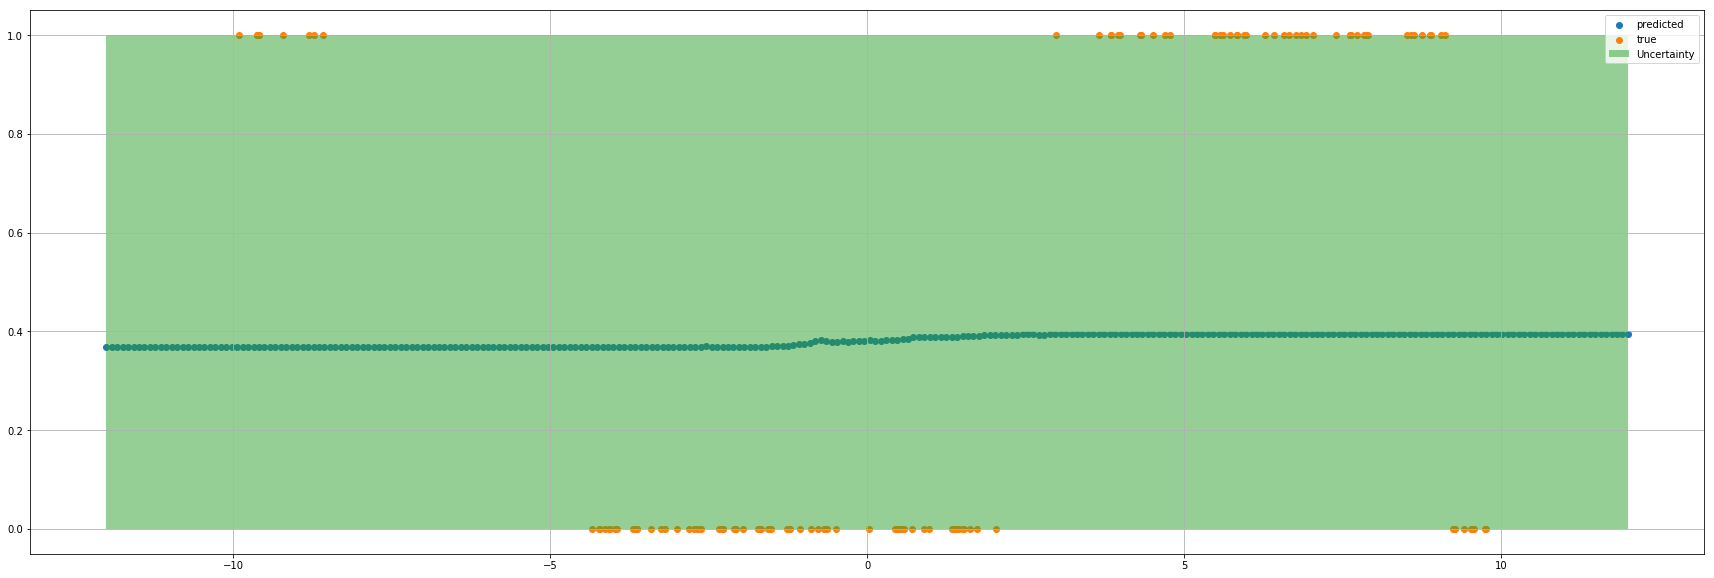

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(30,10))
plt.grid()
plt.scatter(Xtest, mean, label='predicted')
plt.scatter(X, y, label='true')
plt.fill_between(np.array(Xtest).ravel(), 
                 percentile5,
                 percentile95,
                 alpha=0.5, label='Uncertainty')
plt.legend()
plt.show()

In [10]:
data = np.loadtxt('dataSimple/example_data.txt', delimiter=',')
X = data[:,0]
y = data[:,1]

X = np.reshape(X,(X.shape[0],1))
y = np.reshape(y, (y.shape[0],1))

X, y = torch.from_numpy(X).type(torch.FloatTensor), torch.from_numpy(y).type(torch.FloatTensor)

N = X.shape[0] 
M = 280
a, b = np.floor(min(X)), np.ceil(max(X))    
Xtest = torch.from_numpy(np.linspace(a-2, b+2, M).reshape(-1,1)).type(torch.FloatTensor)


In [34]:
from scripts.smallNNRegression import NetRegr
import torch

model = NetRegr()
loss_fn = torch.nn.MSELoss(reduction='sum')
lm = LossModule(model, (X,y), loss_fn)

In [35]:
SGHMC = SGHMCSampler(lm, num_burn_in_steps=5000, lr=0.003, keep_every=50)
SGHMC.sample(nsamples=100)
sampled_weights = SGHMC.sampled_weights

Sampling 500/10000
Sampling 1000/10000
Sampling 1500/10000
Sampling 2000/10000
Sampling 2500/10000
Sampling 3000/10000
Sampling 3500/10000
Sampling 4000/10000
Sampling 4500/10000
Sampling 5000/10000
Sampling 5500/10000
Sampling 6000/10000
Sampling 6500/10000
Sampling 7000/10000
Sampling 7500/10000
Sampling 8000/10000
Sampling 8500/10000
Sampling 9000/10000
Sampling 9500/10000
Sampling 10000/10000


In [36]:
from collections import OrderedDict
outputs = torch.zeros((Xtest.size()[0], len(sampled_weights)))
for j,sample in enumerate(sampled_weights):
    state_dict = {}
    for i,(name, param) in enumerate(model.named_parameters()):
        state_dict[name] = torch.from_numpy(sample[i])
    state_dict_it = OrderedDict(state_dict)
    model.load_state_dict(state_dict_it, strict=False)
    with torch.no_grad():
        outputs[:,j] = torch.squeeze(model(Xtest))
percentile5, percentile95 = np.percentile(outputs.numpy(),5, axis=1), np.percentile(outputs.numpy(),95, axis=1)
mean = torch.mean(outputs, 1)

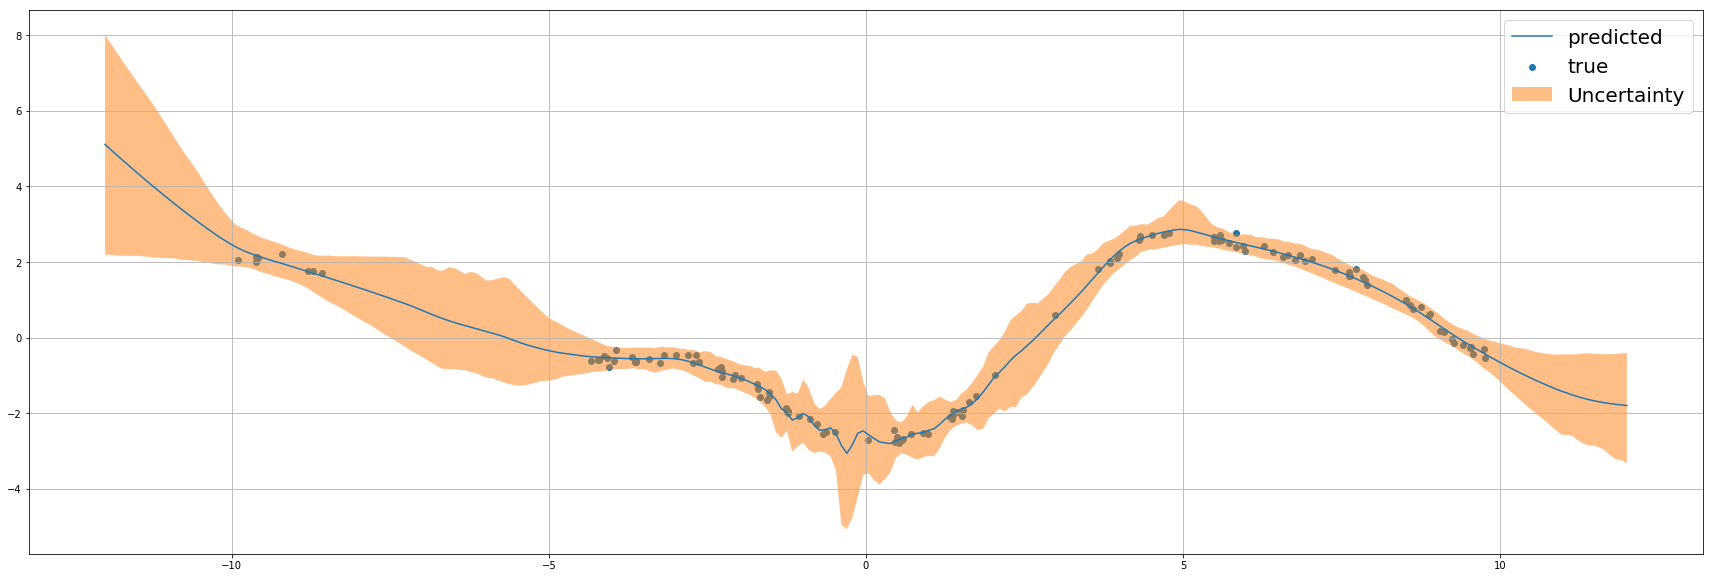

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(30,10))
plt.grid()
plt.plot(Xtest, mean, label='predicted')
plt.scatter(X, y, label='true')
plt.fill_between(np.array(Xtest).ravel(), 
                 percentile5, 
                 percentile95, 
                 alpha=0.5, label='Uncertainty')
plt.legend(fontsize=20)
plt.savefig("imgs/SGHMCRegression.png")
plt.show()